## Problem Statement

This kernel focuses on solving a problem as outlined by [the Human Protein Atlas Image Classification Kaggle competition](https://www.kaggle.com/c/human-protein-atlas-image-classification).

As per the competition overview page:

> In this competition, Kagglers will develop models capable of classifying mixed patterns of proteins in microscope images. The Human Protein Atlas will use these models to build a tool integrated with their smart-microscopy system to identify a protein's location(s) from a high-throughput image.

>Proteins are “the doers” in the human cell, executing many functions that together enable life. Historically, classification of proteins has been limited to single patterns in one or a few cell types, but in order to fully understand the complexity of the human cell, models must classify mixed patterns across a range of different human cells.

>Images visualizing proteins in cells are commonly used for biomedical research, and these cells could hold the key for the next breakthrough in medicine. However, thanks to advances in high-throughput microscopy, these images are generated at a far greater pace than what can be manually evaluated. Therefore, the need is greater than ever for automating biomedical image analysis to accelerate the understanding of human cells and disease.

This should be interesting! Let's start with the necessary imports:

## Imports

In [84]:
import pdb
import sys
import time
import pandas as pd
from sklearn.metrics import f1_score
import pathlib
import copy
import pickle
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from matplotlib import style
style.use('seaborn')

import cv2

import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import torch.nn as nn
from torch import optim, save
import torchvision.models as models

Setting the random seed for both NumPy and PyTorch to allow reproducing results:

In [85]:
seed = 5
np.random.seed(seed)
torch.manual_seed(seed)

In [86]:
PATH = pathlib.Path('../input/human-protein-atlas-image-classification')

In [87]:
[item.name for item in PATH.iterdir()]

['train', 'test', 'train.csv', 'sample_submission.csv']

Now let's define a dictionary of protein organelle localisations which will form the basis of our training labels:

In [88]:
labels_txt = """0.  Nucleoplasm  
1.  Nuclear membrane   
2.  Nucleoli   
3.  Nucleoli fibrillar center   
4.  Nuclear speckles   
5.  Nuclear bodies   
6.  Endoplasmic reticulum   
7.  Golgi apparatus   
8.  Peroxisomes   
9.  Endosomes   
10.  Lysosomes   
11.  Intermediate filaments   
12.  Actin filaments   
13.  Focal adhesion sites   
14.  Microtubules   
15.  Microtubule ends   
16.  Cytokinetic bridge   
17.  Mitotic spindle   
18.  Microtubule organizing center   
19.  Centrosome   
20.  Lipid droplets   
21.  Plasma membrane   
22.  Cell junctions   
23.  Mitochondria   
24.  Aggresome   
25.  Cytosol   
26.  Cytoplasmic bodies   
27.  Rods & rings"""

In [89]:
labels = {int(no): protein.strip() for no, protein in [label.split('.') for label in labels_txt.split('\n')]}

## Importing the dataset

In [90]:
df = pd.read_csv(PATH/'train.csv'); df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


The above dataset provides image `Id`'s wih their respective `Target` labels. The total number of samples is:

In [91]:
df.shape[0]

31072

## Converting the dataset

For further analysis, let's transform the `Target` column into binary features for all labels:

In [179]:
for protein in labels: df[labels[protein]] = df['Target'].apply(lambda x: 1 if str(protein) in x.split(' ') else 0)
df.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,Lysosomes,Intermediate filaments,Actin filaments,Focal adhesion sites,Microtubules,Microtubule ends,Cytokinetic bridge,Mitotic spindle,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Time to verify the balance within the dataset classes:

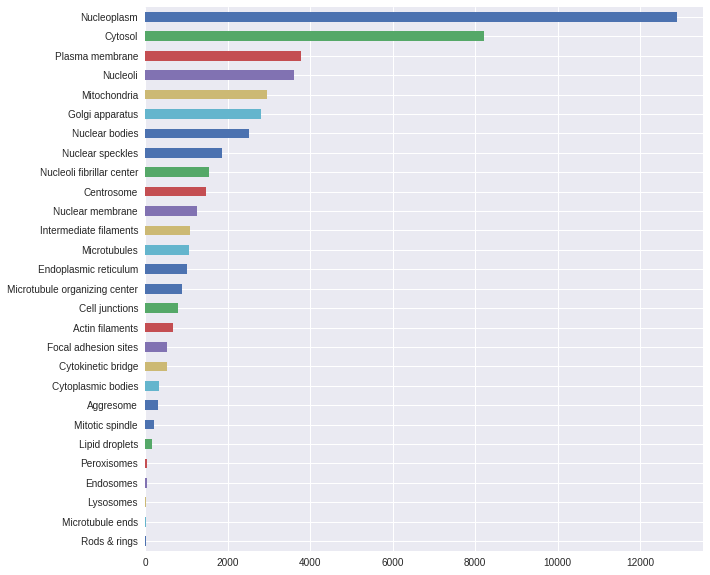

In [93]:
plt.figure(figsize=(10, 10))
df.drop(columns=['Id', 'Target']).sum().sort_values(ascending=False).plot.barh()
plt.gca().invert_yaxis()
plt.show()

In [94]:
counts = df.drop(columns=['Id', 'Target']).sum().sort_values(ascending=False)
for i in range(1, 5): 
    print(f'Top {i} {"labels constitute" if i>1 else "label constitutes"} {counts[:i].sum() / counts.sum() * 100:.2f}% of observations')

Top 1 label constitutes 25.37% of observations
Top 2 labels constitute 41.58% of observations
Top 3 labels constitute 49.01% of observations
Top 4 labels constitute 56.14% of observations


Looks like there is a heavy imbalance in the dataset, in particular towards the top two contributors - Nucleoplasm and Cytosol.

Also we make note that there can be multiple protein connections visible in a particular image. Therefore this is a [*multi-label classification*](https://en.wikipedia.org/wiki/Multi-label_classification) problem - something of note in particular when defining the loss function.

## Data Preprocessing and Augmentation

For each ID in our dataset we get four separate .png images, each covering a different color filter - like in the example below:

In [95]:
[item.name for item in sorted(list((PATH/'train').iterdir()))[:4]]

['00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png',
 '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png',
 '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png',
 '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png']

All images 512x512 color?

In [96]:
# full_set = [item.name for item in (PATH/'train').iterdir()]

We can describe the color filters according to the naming convention used by Human Protein Atlas (the dataset providers):

In [97]:
filter_type = {
    'green': ['protein', 'Greens'],
    'blue': ['nucleus', 'Blues'],
    'red': ['microtubes', 'Reds'],
    'yellow': ['endoplasmic reticulum', 'Oranges']
}

At this stage we have a strategic choice to make: how many filters should be used in our analysis? The likely choices are:
* **Green only** - the authors hint that the proteins of interest are marked on the green filtered images and that these are the main source of information for the manual methods of labelling the images that are used currently
* **Red, Green and Blue** - the three channel view prevails in the Computer Vision community mainly because these are the channels humans recognise with the receptors located in the eye. Using an RGB view would allow us to lift and drop pre-trained CNN architectures to apply them to the problem
* **All filters** - i.e. RGBY. This approach is would be in line with the Data Science pronciples to make use of the most of the data at hand, since it's not easy to understand what parts of it will prove to be useful and which won't beforehand without any expertise in the field

To allow testing various ideas, we will set up the working tools to easily switch between these approaches:

In [98]:
def chan(channels):
    if channels == "G": return 1
    elif channels == "RGB": return 3
    elif channels == "RGBY": return 4
    else: raise Exception("Please provide the correct channel code: [G, RGB, RGBY]")

The below is the main function that will be used throughout this notebook to obtain image matrices from image IDs:

In [99]:
def from_channels(ID, channels="RGBY", test=False, gpu=False):
    folder = 'test' if test else 'train'
    ch = chan(channels)
    image = torch.cuda.FloatTensor(ch, 512, 512).fill_(0)
    if ch == 1: image[0, :, :] = torch.cuda.FloatTensor(plt.imread(str(PATH/f'{folder}/{ID}_green.png')))
    if ch > 2:
        image[0, :, :] = torch.cuda.FloatTensor(plt.imread(str(PATH/f'{folder}/{ID}_red.png')))
        image[1, :, :] = torch.cuda.FloatTensor(plt.imread(str(PATH/f'{folder}/{ID}_green.png')))
        image[2, :, :] = torch.cuda.FloatTensor(plt.imread(str(PATH/f'{folder}/{ID}_blue.png')))

    if ch > 3:
        image[3, :, :] = torch.cuda.FloatTensor(plt.imread(str(PATH/f'{folder}/{ID}_yellow.png')))
    if not gpu: image = np.swapaxes(image.cpu().data.numpy(),0,-1)
    return image

For EDA purposes, we'll define a function to visualise the image, combining the filters into a single view:

In [100]:
def visualise(img, name='', h=7, w=7, show=True, a=1.9, figure=None):
    fig = plt.figure(figsize=(h, w)) if figure is None else figure
    plt.grid(False)
    plt.axis('off')
    plt.title(name)
    alpha = 1
    i = 0
    for colour in filter_type:
        try:
            channel = img[:, :, i]
            plt.imshow(channel, cmap=filter_type[colour][1], alpha=alpha)
            alpha /= a
            i += 1
        except IndexError:
            break
    if show: plt.show()

And to get a better feel of what we're up against, let's see a random image suite combined and each filter separatly:

In [101]:
def from_id(ID):
    targ = df['Target'][df['Id'] == ID].values[0]
    return from_target(targ)


def from_target(targ):
    s = ' & '
    t = [labels[int(t)] for t in targ.split(' ')]
    name = s.join(t) if len(t) > 1 else t[0]
    return name


def set_show(ID: str, ):
    print(from_id(ID))
    fig = plt.figure(figsize=(18, 18))
    i = 1
    combined = []
    for colour in filter_type:
        fig.add_subplot(1, 4, i)
        plt.title(filter_type[colour][0])
        fig.gca().grid(False)
        plt.axis('off')
        img = str(PATH/f'train/{ID}_{colour}.png')
        plt.imshow(plt.imread(img), cmap=filter_type[colour][1])
        combined.append([plt.imread(img), filter_type[colour][1]])
        i += 1
    visualise(from_channels(ID), name='COMBINED VIEW')

Nucleoplasm


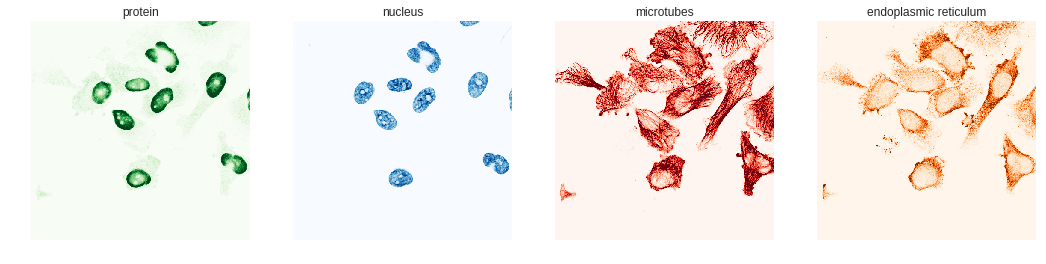

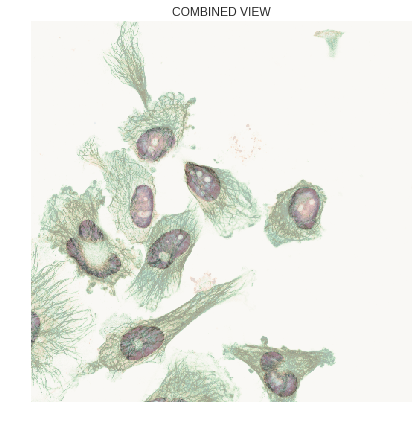

In [102]:
smpl = df['Id'][np.random.randint(0, df.shape[0])]
set_show(smpl)

## Balancing and Transforming the Dataset

At this stage we want to create a training and validation set for the purposes of training the model. Because of the imbalance in the dataset classes and very small count of the minority classes, we want to make sure both the training and validation set are more or less equally representative in terms of the target class distribution. This is why instead of randomly sampling from the entire dataset, we'll be taking a random subset of each target instance and pass it to the validation set. All the one-off target combinations will be treated as one group from which we'll sample:

In [103]:
def get_val_idxs(df, ratio = 0.3):
    n = int(len(df) * ratio)
    target_abundance = df['Target'].value_counts()
    rare = target_abundance[target_abundance == 1].index
    rare_v = np.random.choice(rare, size=int(len(rare) * ratio))
    target_abundance = target_abundance[target_abundance > 1].append(pd.Series({t: 1 for t in rare_v}))
    freq = target_abundance / target_abundance.sum()
    idxs = []
    for t in freq.index:
        idx_t = df[df['Target'] == t].index
        size = max(1, int(freq[t] * n))
        idxs += list(np.random.choice(idx_t, size=size, replace=False))
    np.random.shuffle(idxs)
    return idxs

And now to create the training and validation sets:

In [104]:
idxs = get_val_idxs(df)
idxs = df.index.isin(idxs)
train = df[~idxs].copy()
val = df[idxs].copy()
df.shape, train.shape, val.shape

((31072, 30), (21852, 30), (9220, 30))

The other - potentially bigger - issue we want to address is the imbalance in the training set that is likely to lead to skewing the predictions towards the majority classes. To battle this, we will oversample the dataset, i.e. duplicate instances of rare classes to even out the distribution.

The strategy for the oversampling will be based on assigning multipliers for each observation based on the most rare class instance in the `Target` group. The weights will be log inversely proportional to the class abundance in the total dataset:

In [105]:
def class_multiplier(df, a=0.99):
    class_abundance = df.drop(columns=['Id', 'Target']).sum()
    w = (sum(class_abundance) / class_abundance).apply(lambda x: x if x > 1. else 1.)
    log_w = np.log(a * w).apply(lambda x: x if x > 1. else 1.).astype('int16')
    return log_w


def oversample(df):
    m = class_multiplier(df)
    idxs = [idx for idx in df.index for _ in range(max(df.loc[idx][2:] * m))]
    np.random.shuffle(idxs)
    return idxs

Time to make changes to the training set. For now, we'll take only a 15% subset of the revised observations to allow faster response time during training when testing out ideas:

In [106]:
idxs = oversample(train)
train_template = train.loc[idxs].copy()
train = train_template.sample(frac=0.15)  # ONLY TAKE 15% of OBSERVATIONS
train.shape

(7919, 30)

## Modelling

**Evaluation metric**

The evaluation metric for the competition is the [macro F1 score](https://en.wikipedia.org/wiki/F1_score), meaning minority class F1 scores will be equally as important in calculating the overall score as the majority class scores.

To get some perspective, let's look at two cases that we will also use as benchmark for model evaluation later on - let's calculate the F1 score for a simple case where we state that all cases in the validation set belong to the majority class of Nucleoplasm:

In [107]:
baseline = np.stack([np.array([1] + [0] * (val.shape[1] - 3)) for i in range(val.shape[0])])
ground_truth = val.iloc[:, 2:]
print(f"Nucleoplasm only validation F1 score: {f1_score(baseline, ground_truth, average='macro'):.4f}")

Nucleoplasm only validation F1 score: 0.0209


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Now let's see what happens if we state all validation observations have an instance of all classes:

In [108]:
baseline = np.stack([np.array([1] * (val.shape[1] - 2)) for i in range(val.shape[0])])
ground_truth = val.iloc[:, 2:]
print(f"All classes in all validation images F1 score: {f1_score(baseline, ground_truth, average='macro'):.4f}")

All classes in all validation images F1 score: 0.0990


Now let's implement the metric calculation for the model outputs:

In [109]:
def f1(pred, act, threshold=0.2, average="macro"):
    p = pred.sigmoid().cpu().data.numpy()
    a = act.cpu().data.numpy()
    return f1_score((p > threshold), a, average=average)

**Dataset definition**

Time to define the dataset that will be used the data loader to feed batches to the training loop. We will be experimenting with image sizes in the training process, therefore we want the dataset to incorporate this functionality. Since we want to utilise the GPU computing functionality of PyTorch as much as possible, we'll use the adaptive average pooling function to resize the Torch tensors:

In [110]:
def resize2d(img, size):
    return (F.adaptive_avg_pool2d(img, size).cuda()).data

In [111]:
class ProteinDataset(Dataset):
    
    def __init__(self, dset, channels="RGBY", sz=512, test=False):
        self.dset = dset
        self.channels = channels
        self.sz = (sz, sz)
        self.test = test
        
    def __len__(self):
        return len(self.dset)
    
    def __getitem__(self, idx):
        label = torch.cuda.FloatTensor(self.dset.iloc[idx, 2:])
        ID = self.dset['Id'].iloc[idx]
        img = from_channels(ID, channels=self.channels, test=self.test, gpu=True)
        if img.shape[1:] != self.sz:
            img = resize2d(img, self.sz)
        return [img, label]

**Loss functions**

As noted earlier, this is a *multi-label classification* task - therefore we need to use specific loss functions that allow for optimising such a problem.

In the training process, we will experiment with various loss function definitions to see what works best for our problem. In addition to the loss functions available in PyTorch, we'll define some custom loss functions of our own.

Firstly, we'll try Focal Loss, as described [in this arXiv paper](https://arxiv.org/abs/1708.02002). This is a modification of the popular Cross-Entropy Loss with a tweak to address class imbalance that characterises object detectors. In simple terms, the idea is that learning is focused on a sparse set of "difficult examples" (e.g. the minority classes) by down-weighing the vast number of easy guesses (e.g. majority classes). In other words, the less sure about a correct prediction our model is the more emhasis it will have in the training. Please read this great paper for more details, meanwhile let's define the loss function for our purposes:

In [133]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, inp, targ):
        if not (targ.size() == inp.size()):
            raise ValueError(f"targ size ({targ.size()}) must be the same as inp size ({inp.size()})")

        max_val = (-inp).clamp(min=0)
        loss = inp - inp * targ + max_val + ((-max_val).exp() + (-inp - max_val).exp()).log()

        invprobs = F.logsigmoid(-inp * (targ * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

Another approach we'll be trying out is optimising using the F1 score directly - or rather a "soft" (and differentiable) version of it - to define a loss function. One other benefit of using this loss function is that the results are intuitively interpretable also in the training phase.

In order to avoid dividing by zero while calculating precision and recall, we will use a miniscule element of epsilon in the denominator:

In [113]:
class F1_Loss(nn.Module):
    
    def forward(self, inp, targ):
        inp = inp.sigmoid()
        epsilon = 1e-10

        tp = (inp*targ).sum(dim=0)
        tn = ((1 - inp)*(1-targ)).sum(dim=0)
        fp = (inp*(1-targ)).sum(dim=0)
        fn = ((1-inp)*targ).sum(dim=0)

        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)

        f1 = 2 * precision * recall / (precision + recall + epsilon)
        return 1 - f1.mean()

Lastly, we'll try out a linear interpolation of the two custom loss functions:

In [131]:
class Combined_Loss(nn.Module):
    
    def __init__(self, alpha=0.7):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, inp, targ):
        combined_loss = (self.alpha)*F1_Loss().cuda()(inp, targ) + (1-self.alpha)*FocalLoss().cuda()(inp, targ)
        return combined_loss

**Training loop**

Now time to define the training loop. Firstly, we define the evaluation function that will be performed on the validation set at the end of every epoch to give us an understanding of how well the model is performing against the F1 score:

In [ ]:
def evaluate(model, val_loader, threshold=0.2, average="macro"):
    """
    Evaluation of model performance on the validation set
    """
    preds = []
    acts = []
    for v in val_loader:
        X, y = v
        pred = model(X).sigmoid().cpu().data.numpy()
        act = y.cpu().data.numpy()
        preds.append(pred)
        acts.append(act)
    preds = np.concatenate(preds)
    acts = np.concatenate(acts)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f1 = f1_score(preds > threshold, acts, average=average)
    return f1

Now we define the training loop itself. It will implement learning rate annealing with restarts (inspired by [this arXiv paper](https://arxiv.org/abs/1506.01186)) - here implemented as cosine annealing, i.e. reducing the learning rate according to the cosine function on a cyclical basis (at the start of the epoch by default, can be tweaked using the `cycles` parameter). The loss function will be passed in as a parameter for ease of experimenting later on:****

In [136]:
def train_cnn(model, train_loader, val_loader, n_epochs, lr, loss=F1_Loss().cuda(),
              channels="RGBY", prints_per_epoch=10, annealing=True, cycles=1, t=0.5):
    """
    Main training loop of the model
    """
    
    # Start of training printing:
    print("HYPERPARAMETERS\n", "_"*30, f"\nBatch size (w. augs): {bs}\nLearning rate: {lr}\nNumber of Epochs: {n_epochs}\n", "_"*30)  
    n_batches = len(train_loader)
    training_start_time = time.time()
    print_every = n_batches // prints_per_epoch
    print_loss = []
    
    opt = optim.Adam(model.parameters(), lr=lr)    

    # Main loop:
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()
        total_train_loss = 0
        
        # Reset the scheduler at the start of the cycle:
        if epoch % cycles == 0 and annealing: 
            scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, len(train_loader) * cycles, eta_min=lr/1e4)
        
        # Batch loop:
        for i, data in enumerate(train_loader, 0):
            inp, lab = data
            opt.zero_grad()
            out = model(inp)
            loss_size = loss(out, lab)
            loss_size.backward()
            opt.step()
            if annealing: scheduler.step()
            
            running_loss += loss_size.item()
            
            # Intra-epoch printing:
            if (i + 1) % (print_every + 1) == 0:
                print(f"Epoch {epoch + 1} [{100 * (i + 1) / n_batches:.0f}% done] - Training Loss: {running_loss / print_every:.4f}, Elapsed Time: {time.time() - start_time:.0f}s")
                print_loss.append(running_loss / print_every)
                running_loss = 0.0
                start_time = time.time()
                
        # End of epoch printing:
        print("-"*40, f"\nEnd of Epoch {epoch + 1} Validation F1: {evaluate(model=model, val_loader=val_loader, threshold=t):.4f}\n","_"*40)
    total_time = int(time.time() - training_start_time)
    
    # End of training printing:
    print(f"TRAINING COMPLETE - Total Elapsed Time: {total_time // 60}m{total_time % 60}s")
    
    # End of training loss function plot:
    if prints_per_epoch:
        plt.figure()
        plt.plot(print_loss)
        plt.ylabel("Loss")
        plt.xticks([], [])
        plt.show()

Before training ensues, we'll try to get a feel of what learning rate should be picked as a starting point using our own version of a learning rate finder. 

The simple idea behind this is performing a sequence of batch loss calculations with gradually increasing learning rates to understand the level that gives us the biggest of loss reducton before starting to diverge:

In [118]:
def find_lr(model, train_loader, loss, crop=1, p=10):
    """
    Function aimed to assist in finding the optimal learning rate
    """
    model = copy.deepcopy(model)
    p += crop
    lrs = [round(eval("1e-" + str(p)) * 10**i, p - i) for i in range(p + 1)] + [2]
    losses = []
    for lr in lrs:
        opt = optim.Adam(params=model.parameters(), lr=lr)
        inp, lab = next(iter(train_loader))
        opt.zero_grad()
        out = model(inp)
        loss_size = loss(out, lab)
        loss_size.backward()
        opt.step()
        losses.append(float(loss_size.cpu().data.numpy()))
    los = losses[1 + crop:-crop]
    lrs = lrs[crop:-(crop + 1)]
    
    
    plt.plot(los)
    plt.xticks(list(range(len(los))), lrs, rotation='vertical')
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.show()

**Model Architecture**

The architecture that will be implemented for training will be based on a ResNet34 pre-trained model (to learn more about ResNets in general, [look here](https://arxiv.org/abs/1512.03385)). Some of the customisation that we will apply to it includes:
* when using 4 channels (RGBY), the fourth channel weights are initialised as average of the remaining three instead of random
* modifying the average pooling after following the convolution part to output 1 activation per filter
* introducing functionality to freeze the weights of the ResNet part of the model - this will be useful in the early stages of training and during image resizing
* creating a custom linear layer based 'head' to output the predicted classes based on the convolution layers
* trying out various non-linearity functions in the custom head

In [120]:
class ResNetBased(nn.Module):
    
    def __init__(self, channels="RGBY", activation="ReLU", dropout=0.3):
        super().__init__()
        self.d = dropout
        
        self.image_channels = 1 if channels == "G" else 3 if channels == "RGB" else 4
        
        if activation == "ReLU":
            self.act = nn.ReLU()
        elif activation == "PReLU":
            self.act = nn.PReLU()
        elif activation == "LReLU":
            self.act = nn.LeakyReLU(0.02)
        else:
            raise Exception("Please choose activation: ReLU, PReLU or LReLU")
        
        # Pre-trained ResNet import:
        self.model = models.resnet34(pretrained=True)
        
        self.model.conv1 = nn.Conv2d(self.image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Initialising the fourth channel weights:
        if self.image_channels == 4:
            w = models.resnet34(pretrained=True).conv1.weight
            w = torch.cat((w, w.mean(dim=1, keepdim=True)), dim=1)
            self.model.conv1.weight = nn.Parameter(w)
        self.model.relu = self.act
        self.model.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.in_feats = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(self.in_feats, 512),
            nn.BatchNorm1d(512,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(self.d),
            self.act
        )
        
        # Custom head
        self.head = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(self.d),
            self.act,
            nn.Linear(128, len(labels))
        )
        print(self)
        
    def forward(self, x):
        x = self.model(x)
        x = self.head(x)
        return x
    
    def freeze_pretrained(self, freeze_state=False):
        for p in self.model.parameters():
            p.requires_grad = freeze_state

**Training the Model**

Time to commence the training! We first define the initial parameters for training, such as image size (`sz`) and batch size (`bs`), the number of channels. Based on these, we will be able to create the datasets and loaders to use in the training cycle with the `get_data` function:

In [143]:
def get_data(sz, bs, channels):
    global dset, vset, train_loader, val_loader, b, y
    dset = ProteinDataset(train, channels=channels, sz=sz)
    vset = ProteinDataset(val, channels=channels, sz=sz)
    train_loader = DataLoader(dset, batch_size=bs)
    val_loader = DataLoader(vset, batch_size=bs)
    b, y = next(iter(train_loader))

We'll set the initial image size to 64 - a significant reduction compared to the provided size 512. However, this will accelerate the initial stages of the training and at later stages we will be able to gradually increase the image sizes to make use of the full information:

In [144]:
sz = 64
bs = 64
channels = "RGBY"
get_data(sz, bs, channels)

Now, let's create an instance of the model:

In [149]:
model = ResNetBased(channels=channels, activation="LReLU").cuda()

ResNetBased(
  (act): LeakyReLU(negative_slope=0.02)
  (model): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.02)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64

To better guide the validation review, we will review the F1 score on a subsample of the validation set using thresholds in the range of 0.1-0.9 to have a high-level feel about how confident our model is becoming about the predictions. From these thresholds, the one resulting in the highest F1 will be used in the further validation reviews:

In [125]:
def f1_thresholds():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        d = {round(t*0.1,1): round(f1(model(b), y, threshold=t*0.1),4) for t in range(1,11)}
    return d


def opt_th(): return sorted(f1_thresholds().items(), key=lambda x: x[1])[-1][0]

In [148]:
loss=F1_Loss().cuda()

OK! Now, let's start by finding the best learning rate for our problem:

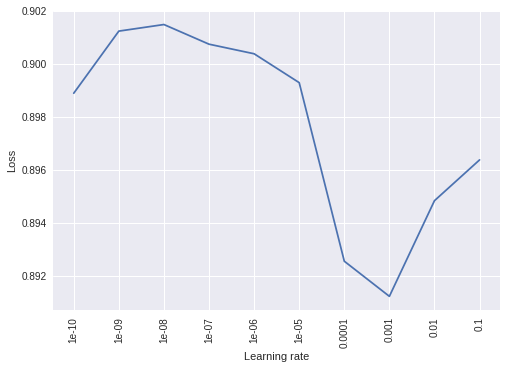

In [150]:
find_lr(model=model, loss=loss, train_loader=train_loader, crop=1)

The optimal learning rate appears to be between 1e-4 and 1e-3 - we'll go for 5e-4 then:

In [151]:
lr=5e-4

At the initial stage of the training our model has pre-trained weights in the convolutional part and randomly initialised weights in the custom head. In order to prevent altering the pre-trained weights too significantly with gradients meant to remove randomness from the head part, we will freeze the pre-trained weights at first:

In [152]:
model.freeze_pretrained(True)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 64
Learning rate: 0.0005
Number of Epochs: 1
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.9782, Elapsed Time: 23s
Epoch 1 [21% done] - Training Loss: 0.9758, Elapsed Time: 22s
Epoch 1 [31% done] - Training Loss: 0.9721, Elapsed Time: 23s
Epoch 1 [42% done] - Training Loss: 0.9677, Elapsed Time: 23s
Epoch 1 [52% done] - Training Loss: 0.9662, Elapsed Time: 23s
Epoch 1 [63% done] - Training Loss: 0.9613, Elapsed Time: 23s
Epoch 1 [73% done] - Training Loss: 0.9627, Elapsed Time: 22s
Epoch 1 [84% done] - Training Loss: 0.9636, Elapsed Time: 22s
Epoch 1 [94% done] - Training Loss: 0.9613, Elapsed Time: 22s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1034
 ________________________________________
TRAINING COMPLETE - Total Elapsed Time: 7m30s


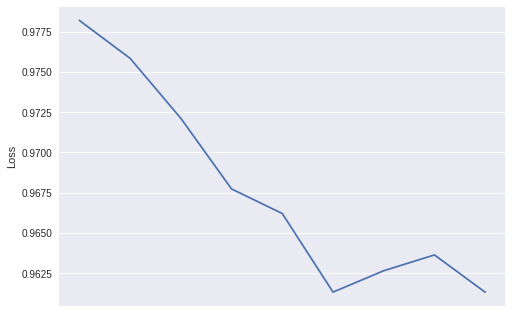

In [153]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=1,
          annealing=True, cycles=1, t=0.3, loss=loss)

In [154]:
f1_thresholds()

{0.1: 0.1115,
 0.2: 0.1119,
 0.3: 0.1154,
 0.4: 0.12,
 0.5: 0.1401,
 0.6: 0.1492,
 0.7: 0.1275,
 0.8: 0.093,
 0.9: 0.0213,
 1.0: 0.0}

Now, time to let the gradient pass also to the convolutional part, we unfreeze the layers. Since recognising proteins seems to be a task quite different to recognising contents of ImageNet pictures, we expect this to be really needed!

In [155]:
model.freeze_pretrained(False)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 64
Learning rate: 0.0005
Number of Epochs: 3
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.9602, Elapsed Time: 21s
Epoch 1 [21% done] - Training Loss: 0.9574, Elapsed Time: 21s
Epoch 1 [31% done] - Training Loss: 0.9553, Elapsed Time: 22s
Epoch 1 [42% done] - Training Loss: 0.9508, Elapsed Time: 22s
Epoch 1 [52% done] - Training Loss: 0.9480, Elapsed Time: 22s
Epoch 1 [63% done] - Training Loss: 0.9447, Elapsed Time: 22s
Epoch 1 [73% done] - Training Loss: 0.9477, Elapsed Time: 22s
Epoch 1 [84% done] - Training Loss: 0.9510, Elapsed Time: 22s
Epoch 1 [94% done] - Training Loss: 0.9503, Elapsed Time: 23s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---------------------------------------- 
End of Epoch 1 Validation F1: 0.1368
 ________________________________________
Epoch 2 [10% done] - Training Loss: 0.9495, Elapsed Time: 21s
Epoch 2 [21% done] - Training Loss: 0.9463, Elapsed Time: 22s
Epoch 2 [31% done] - Training Loss: 0.9445, Elapsed Time: 22s
Epoch 2 [42% done] - Training Loss: 0.9403, Elapsed Time: 22s
Epoch 2 [52% done] - Training Loss: 0.9371, Elapsed Time: 22s
Epoch 2 [63% done] - Training Loss: 0.9346, Elapsed Time: 22s
Epoch 2 [73% done] - Training Loss: 0.9372, Elapsed Time: 22s
Epoch 2 [84% done] - Training Loss: 0.9419, Elapsed Time: 22s
Epoch 2 [94% done] - Training Loss: 0.9416, Elapsed Time: 21s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---------------------------------------- 
End of Epoch 2 Validation F1: 0.1414
 ________________________________________
Epoch 3 [10% done] - Training Loss: 0.9402, Elapsed Time: 22s
Epoch 3 [21% done] - Training Loss: 0.9359, Elapsed Time: 22s
Epoch 3 [31% done] - Training Loss: 0.9349, Elapsed Time: 22s
Epoch 3 [42% done] - Training Loss: 0.9299, Elapsed Time: 22s
Epoch 3 [52% done] - Training Loss: 0.9271, Elapsed Time: 22s
Epoch 3 [63% done] - Training Loss: 0.9240, Elapsed Time: 22s
Epoch 3 [73% done] - Training Loss: 0.9273, Elapsed Time: 22s
Epoch 3 [84% done] - Training Loss: 0.9328, Elapsed Time: 22s
Epoch 3 [94% done] - Training Loss: 0.9336, Elapsed Time: 22s
---------------------------------------- 
End of Epoch 3 Validation F1: 0.1436
 ________________________________________
TRAINING COMPLETE - Total Elapsed Time: 22m3s


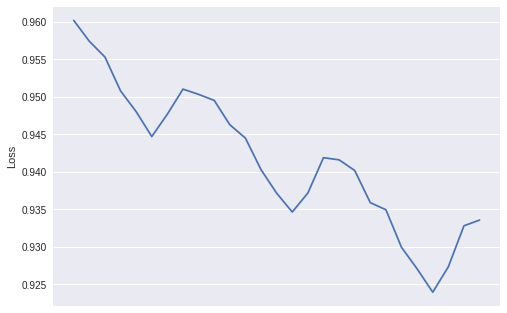

In [156]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=3, 
          annealing=True, cycles=1, t=opt_th(), loss=loss)

In [157]:
f1_thresholds()

{0.1: 0.1277,
 0.2: 0.1399,
 0.3: 0.1569,
 0.4: 0.1612,
 0.5: 0.1677,
 0.6: 0.1701,
 0.7: 0.1699,
 0.8: 0.1743,
 0.9: 0.1364,
 1.0: 0.0}

After the initial training, we can increase the image size:

In [158]:
sz = 128
get_data(sz, bs, channels)

Again we will make use of the `freeze_pretrained` functionality to allow the custom head to tune to the increased image size first - this is a pattern we will continue for all subsequent image size increases:

In [159]:
model.freeze_pretrained(True)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 64
Learning rate: 0.0005
Number of Epochs: 1
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.9415, Elapsed Time: 26s
Epoch 1 [21% done] - Training Loss: 0.9321, Elapsed Time: 27s
Epoch 1 [31% done] - Training Loss: 0.9334, Elapsed Time: 27s
Epoch 1 [42% done] - Training Loss: 0.9275, Elapsed Time: 27s
Epoch 1 [52% done] - Training Loss: 0.9272, Elapsed Time: 27s
Epoch 1 [63% done] - Training Loss: 0.9201, Elapsed Time: 26s
Epoch 1 [73% done] - Training Loss: 0.9242, Elapsed Time: 26s
Epoch 1 [84% done] - Training Loss: 0.9264, Elapsed Time: 27s
Epoch 1 [94% done] - Training Loss: 0.9210, Elapsed Time: 27s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1507
 ________________________________________
TRAINING COMPLETE - Total Elapsed Time: 8m17s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


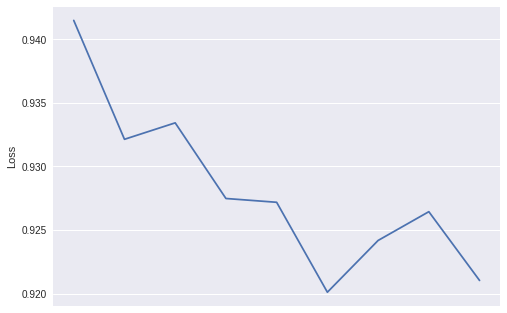

In [160]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=1, 
          annealing=True, cycles=1, t=opt_th(), loss=loss)

In [161]:
f1_thresholds()

{0.1: 0.1521,
 0.2: 0.1597,
 0.3: 0.1672,
 0.4: 0.1752,
 0.5: 0.1827,
 0.6: 0.1931,
 0.7: 0.1939,
 0.8: 0.1902,
 0.9: 0.1693,
 1.0: 0.0}

In [162]:
model.freeze_pretrained(False)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 64
Learning rate: 0.0005
Number of Epochs: 3
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.9190, Elapsed Time: 22s
Epoch 1 [21% done] - Training Loss: 0.9155, Elapsed Time: 22s
Epoch 1 [31% done] - Training Loss: 0.9171, Elapsed Time: 23s
Epoch 1 [42% done] - Training Loss: 0.9116, Elapsed Time: 22s
Epoch 1 [52% done] - Training Loss: 0.9106, Elapsed Time: 23s
Epoch 1 [63% done] - Training Loss: 0.9075, Elapsed Time: 23s
Epoch 1 [73% done] - Training Loss: 0.9114, Elapsed Time: 22s
Epoch 1 [84% done] - Training Loss: 0.9157, Elapsed Time: 23s
Epoch 1 [94% done] - Training Loss: 0.9143, Elapsed Time: 22s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---------------------------------------- 
End of Epoch 1 Validation F1: 0.1505
 ________________________________________
Epoch 2 [10% done] - Training Loss: 0.9116, Elapsed Time: 22s
Epoch 2 [21% done] - Training Loss: 0.9088, Elapsed Time: 22s
Epoch 2 [31% done] - Training Loss: 0.9112, Elapsed Time: 22s
Epoch 2 [42% done] - Training Loss: 0.9071, Elapsed Time: 23s
Epoch 2 [52% done] - Training Loss: 0.9049, Elapsed Time: 22s
Epoch 2 [63% done] - Training Loss: 0.9028, Elapsed Time: 22s
Epoch 2 [73% done] - Training Loss: 0.9064, Elapsed Time: 23s
Epoch 2 [84% done] - Training Loss: 0.9117, Elapsed Time: 22s
Epoch 2 [94% done] - Training Loss: 0.9106, Elapsed Time: 22s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


---------------------------------------- 
End of Epoch 2 Validation F1: 0.1521
 ________________________________________
Epoch 3 [10% done] - Training Loss: 0.9064, Elapsed Time: 22s
Epoch 3 [21% done] - Training Loss: 0.9052, Elapsed Time: 22s
Epoch 3 [31% done] - Training Loss: 0.9067, Elapsed Time: 23s
Epoch 3 [42% done] - Training Loss: 0.9015, Elapsed Time: 22s
Epoch 3 [52% done] - Training Loss: 0.9009, Elapsed Time: 22s
Epoch 3 [63% done] - Training Loss: 0.8991, Elapsed Time: 22s
Epoch 3 [73% done] - Training Loss: 0.9017, Elapsed Time: 22s
Epoch 3 [84% done] - Training Loss: 0.9076, Elapsed Time: 22s
Epoch 3 [94% done] - Training Loss: 0.9074, Elapsed Time: 22s
---------------------------------------- 
End of Epoch 3 Validation F1: 0.1545
 ________________________________________
TRAINING COMPLETE - Total Elapsed Time: 22m42s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


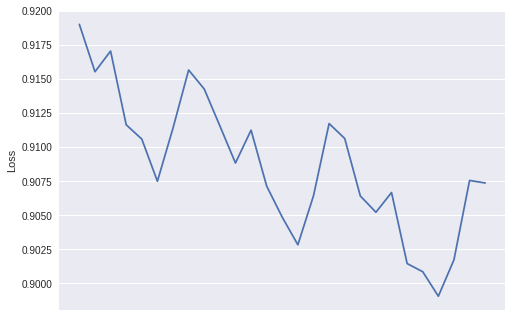

In [163]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=3, 
          annealing=True, cycles=1, t=opt_th(), loss=loss)

In [164]:
f1_thresholds()

{0.1: 0.1772,
 0.2: 0.184,
 0.3: 0.1917,
 0.4: 0.1945,
 0.5: 0.1922,
 0.6: 0.2113,
 0.7: 0.2014,
 0.8: 0.2063,
 0.9: 0.1834,
 1.0: 0.0}

In [165]:
sz = 256
bs = 32
get_data(sz, bs, channels)

In [166]:
model.freeze_pretrained(True)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 32
Learning rate: 0.0005
Number of Epochs: 1
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.8984, Elapsed Time: 42s
Epoch 1 [20% done] - Training Loss: 0.8877, Elapsed Time: 43s
Epoch 1 [30% done] - Training Loss: 0.8846, Elapsed Time: 43s
Epoch 1 [40% done] - Training Loss: 0.8858, Elapsed Time: 43s
Epoch 1 [50% done] - Training Loss: 0.8759, Elapsed Time: 43s
Epoch 1 [60% done] - Training Loss: 0.8790, Elapsed Time: 43s
Epoch 1 [71% done] - Training Loss: 0.8740, Elapsed Time: 43s
Epoch 1 [81% done] - Training Loss: 0.8765, Elapsed Time: 43s
Epoch 1 [91% done] - Training Loss: 0.8690, Elapsed Time: 43s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1642
 ________________________________________
TRAINING COMPLETE - Total Elapsed Time: 12m6s


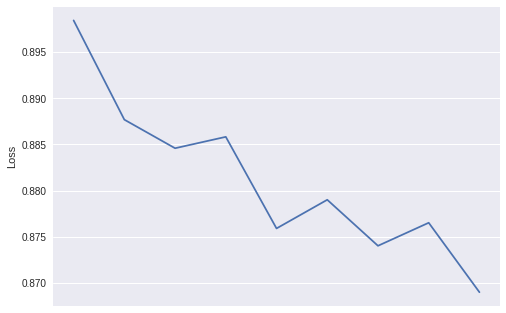

In [167]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=1, 
          annealing=True, cycles=1, t=opt_th(), loss=loss)

In [168]:
f1_thresholds()

{0.1: 0.1604,
 0.2: 0.1571,
 0.3: 0.1631,
 0.4: 0.177,
 0.5: 0.1501,
 0.6: 0.1773,
 0.7: 0.1891,
 0.8: 0.2044,
 0.9: 0.1685,
 1.0: 0.0}

In [169]:
model.freeze_pretrained(False)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 32
Learning rate: 0.0005
Number of Epochs: 3
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.8646, Elapsed Time: 26s
Epoch 1 [20% done] - Training Loss: 0.8678, Elapsed Time: 27s
Epoch 1 [30% done] - Training Loss: 0.8687, Elapsed Time: 27s
Epoch 1 [40% done] - Training Loss: 0.8653, Elapsed Time: 27s
Epoch 1 [50% done] - Training Loss: 0.8590, Elapsed Time: 27s
Epoch 1 [60% done] - Training Loss: 0.8642, Elapsed Time: 26s
Epoch 1 [71% done] - Training Loss: 0.8620, Elapsed Time: 26s
Epoch 1 [81% done] - Training Loss: 0.8665, Elapsed Time: 27s
Epoch 1 [91% done] - Training Loss: 0.8618, Elapsed Time: 26s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1690
 ________________________________________
Epoch 2 [10% done] - Training Loss: 0.8602, Elapsed Time: 26s
Epoch 2 [20% done] - Training Loss: 0.8620, Elapsed Time: 26s
Epoch 2 [30% done] - Training Loss: 0.8660, Elaps

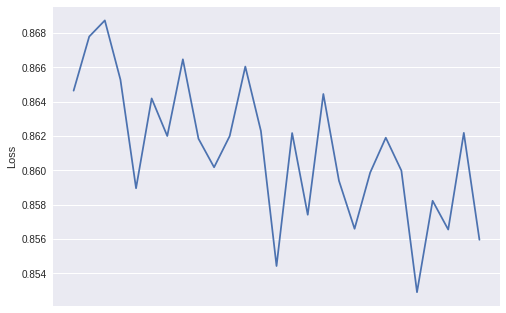

In [170]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=3, 
          annealing=True, cycles=1, t=opt_th(), loss=loss)

In [171]:
f1_thresholds()

{0.1: 0.1724,
 0.2: 0.1844,
 0.3: 0.1801,
 0.4: 0.2014,
 0.5: 0.1902,
 0.6: 0.2048,
 0.7: 0.1981,
 0.8: 0.1891,
 0.9: 0.1681,
 1.0: 0.0}

In [172]:
sz = 512
get_data(sz, bs, channels)

In [173]:
model.freeze_pretrained(True)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 32
Learning rate: 0.0005
Number of Epochs: 1
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.8717, Elapsed Time: 106s
Epoch 1 [20% done] - Training Loss: 0.8734, Elapsed Time: 105s
Epoch 1 [30% done] - Training Loss: 0.8722, Elapsed Time: 105s
Epoch 1 [40% done] - Training Loss: 0.8713, Elapsed Time: 105s
Epoch 1 [50% done] - Training Loss: 0.8556, Elapsed Time: 105s
Epoch 1 [60% done] - Training Loss: 0.8629, Elapsed Time: 105s
Epoch 1 [71% done] - Training Loss: 0.8514, Elapsed Time: 105s
Epoch 1 [81% done] - Training Loss: 0.8563, Elapsed Time: 105s
Epoch 1 [91% done] - Training Loss: 0.8450, Elapsed Time: 105s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1938
 ________________________________________
TRAINING COMPLETE - Total Elapsed Time: 26m6s


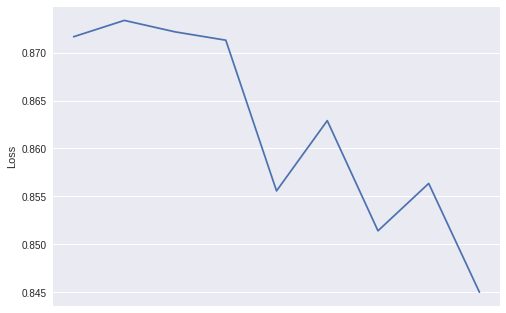

In [174]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=1, 
          annealing=True, cycles=1, t=opt_th(), loss=loss)

In [175]:
f1_thresholds()

{0.1: 0.1827,
 0.2: 0.1907,
 0.3: 0.2197,
 0.4: 0.2287,
 0.5: 0.2156,
 0.6: 0.2041,
 0.7: 0.1779,
 0.8: 0.165,
 0.9: 0.1787,
 1.0: 0.0}

In [176]:
model.freeze_pretrained(False)

HYPERPARAMETERS
 ______________________________ 
Batch size (w. augs): 32
Learning rate: 0.0005
Number of Epochs: 3
 ______________________________
Epoch 1 [10% done] - Training Loss: 0.8423, Elapsed Time: 46s
Epoch 1 [20% done] - Training Loss: 0.8412, Elapsed Time: 46s
Epoch 1 [30% done] - Training Loss: 0.8453, Elapsed Time: 46s
Epoch 1 [40% done] - Training Loss: 0.8421, Elapsed Time: 46s
Epoch 1 [50% done] - Training Loss: 0.8354, Elapsed Time: 47s
Epoch 1 [60% done] - Training Loss: 0.8470, Elapsed Time: 46s
Epoch 1 [71% done] - Training Loss: 0.8387, Elapsed Time: 46s
Epoch 1 [81% done] - Training Loss: 0.8419, Elapsed Time: 46s
Epoch 1 [91% done] - Training Loss: 0.8383, Elapsed Time: 46s
---------------------------------------- 
End of Epoch 1 Validation F1: 0.1934
 ________________________________________
Epoch 2 [10% done] - Training Loss: 0.8372, Elapsed Time: 46s
Epoch 2 [20% done] - Training Loss: 0.8350, Elapsed Time: 46s
Epoch 2 [30% done] - Training Loss: 0.8413, Elaps

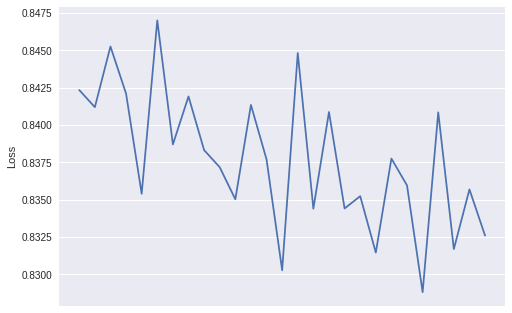

In [177]:
train_cnn(model=model, train_loader=train_loader, val_loader=val_loader, lr=lr, n_epochs=3, 
          annealing=True, cycles=1, t=opt_th(), loss=loss)

In [178]:
f1_thresholds()

{0.1: 0.2022,
 0.2: 0.1994,
 0.3: 0.2127,
 0.4: 0.2169,
 0.5: 0.219,
 0.6: 0.2398,
 0.7: 0.2001,
 0.8: 0.1673,
 0.9: 0.1787,
 1.0: 0.0}